['bike01.jpg', 'bike02.jpg', 'bike03.jpg', 'bike04.jpg', 'bike05.jpg', 'bike06.jpg', 'bike07.jpg', 'bike08.jpg', 'bike09.jpg', 'bike10.jpg']
bicycle
[3, 16, 412, 410]


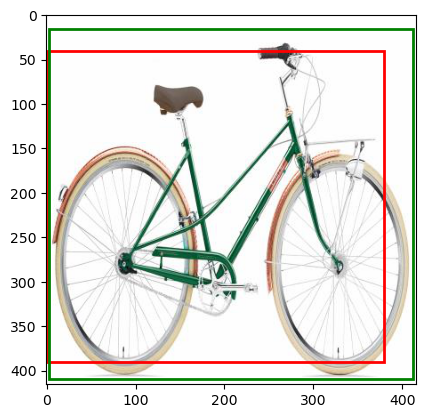

bicycle
[9, 90, 366, 321]


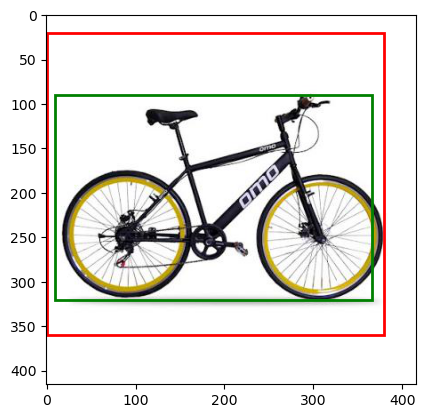

bicycle
[155, 153, 338, 405]


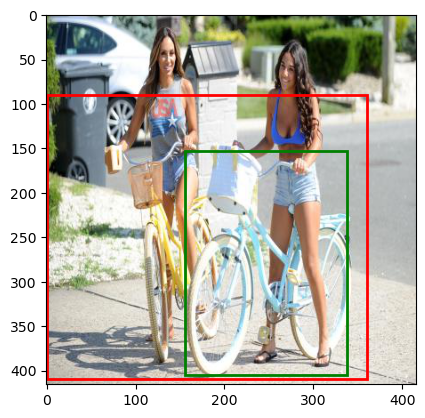

bicycle
[0, 2, 414, 412]


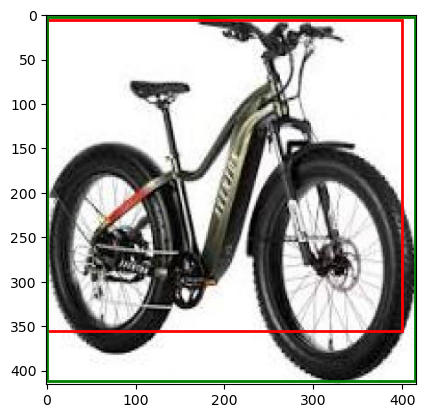

bicycle
[66, 36, 349, 335]


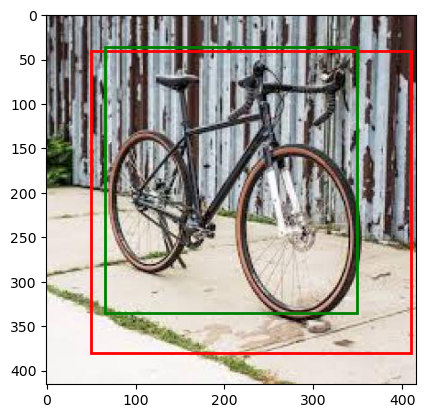

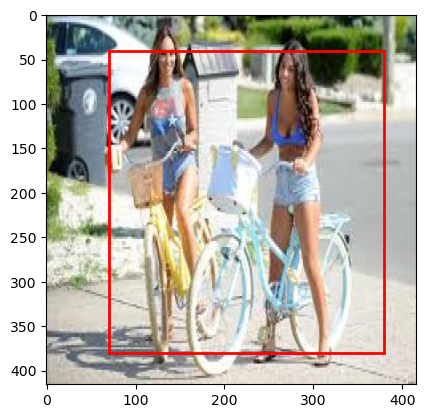

bicycle
[51, 206, 308, 416]


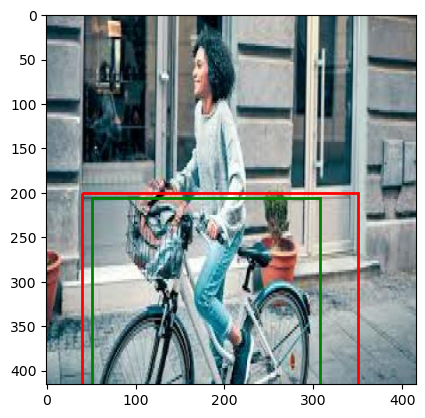

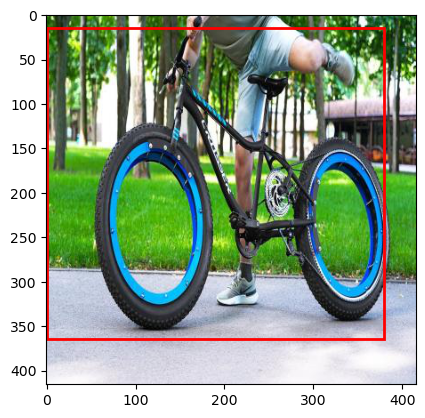

bicycle
[4, 14, 371, 402]


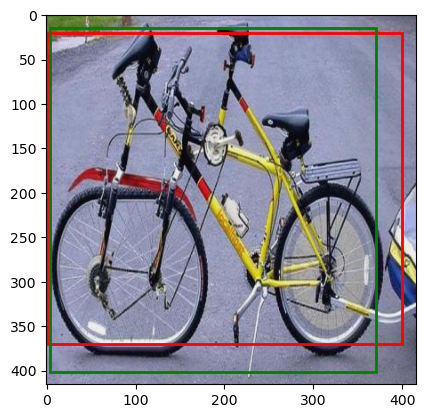

bicycle
[138, 135, 391, 404]


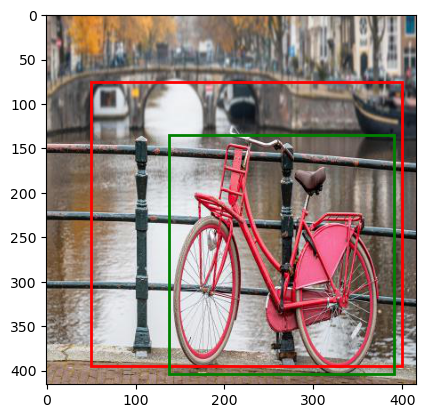

Iou 0.6633482912341254
Mse 2276.3125
RMSE 47.71071682546805


In [4]:
import math
#Pentru imaginile care contin biciclete:

#a. sa se localizeze automat bicicletele in aceste imagini si sa se evidentieze chenarele care incadreaza bicicletele

#b. sa se eticheteze (fara ajutorul algoritmilor de AI) aceste imagini cu chenare care sa incadreze cat mai exact bicicletele. Care task dureaza mai mult (cel de la punctul a sau cel de la punctul b)?

#c. sa se determine performanta algoritmului de la punctul a avand in vedere etichetarile realizate la punctul b (se vor folosi cel putin 2 metrici).

from dotenv import load_dotenv
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import VisualFeatureTypes
from msrest.authentication import CognitiveServicesCredentials
import os
import matplotlib.pyplot as plt

load_dotenv()

subscription_key = os.environ.get('AZURE_SUBSCRIPTION_KEY')
endpoint = os.environ.get('AZURE_ENDPOINT')

cv_client = ComputerVisionClient(endpoint, CognitiveServicesCredentials(subscription_key))

locations = {
    "bike01": [0, 40, 380, 350],
    "bike02": [0, 20, 380, 340],
    "bike03": [0, 90, 360, 320],
    "bike04": [0, 5, 400, 350],
    "bike05": [50, 40, 360, 340],
    "bike06": [70, 40, 310, 340],
    "bike07": [40, 200, 310, 320],
    "bike08": [0, 15, 380, 350],
    "bike09": [0, 20, 400, 350],
    "bike10": [50, 75, 350, 320]
}

def iou_metric(box1, box2):
   
    x_stanga = max(box1[0], box2[0])
    y_stanga = max(box1[1], box2[1])
    x_dreapta = min(box1[2], box2[2])
    y_dreapta = min(box1[3], box2[3])
    if x_dreapta > x_stanga and y_dreapta > y_stanga:
        intersection = (x_dreapta - x_stanga) * (y_dreapta - y_stanga)
        box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
        box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
        union = box1_area + box2_area - intersection
        iou = intersection / union
        return iou
    else:
        return 0

def mse_metric(box1, box2):
    err = 0
    for v in zip(box1, box2):
        err = err + (v[0] - v[1])**2
    err = err / 4
    return err


def object_location():
    name = os.listdir("images/bikes")
    bike_images = [f for f in name if f.startswith("bike")]
    print(bike_images)
    
    iou_results = []
    mse_results = []
    for imag in bike_images:
        image_path = "images/bikes/" + imag
        image_name = imag.split(".")[0]
        im = plt.imread(image_path)
        fig, ax = plt.subplots(1)
        ax.imshow(im)
        
        manual_x, manual_y, manual_width, manual_height = locations[image_name]
        manual_box = [manual_x, manual_y, manual_width + manual_x, manual_height + manual_y]
        ax.add_patch(plt.Rectangle(xy=(manual_x, manual_y), width=manual_width, height=manual_height, fill=False, color="red",linewidth=2))
        
        img = open(image_path, "rb")
        result = cv_client.analyze_image_in_stream(img, visual_features=[VisualFeatureTypes.objects])

        for obj in result.objects:
            if obj.object_property == "bike" or obj.object_property == "bicycle":
                print(obj.object_property)
                predicted_bike = [obj.rectangle.x, obj.rectangle.y, obj.rectangle.x + obj.rectangle.w,
                                  obj.rectangle.y + obj.rectangle.h]
                ax.axes.add_patch(plt.Rectangle(xy=(predicted_bike[0], predicted_bike[1]),width=predicted_bike[2] - predicted_bike[0],height=predicted_bike[3] - predicted_bike[1], fill=False, color="green",linewidth=2))
                
                print(predicted_bike)
                
                iou = iou_metric(manual_box, predicted_bike)
                iou_results.append(iou)
                
                mse = mse_metric(manual_box, predicted_bike)
                mse_results.append(mse)
        plt.show() 
        
    mean_iou = sum(iou_results) / len(iou_results) if len(iou_results) > 0 else 0
    mean_mse = sum(mse_results) / len(mse_results) if len(mse_results) > 0 else 0
    print("Iou", mean_iou)
    print("Mse", mean_mse)
    print("RMSE", math.sqrt(mean_mse))


object_location()


